In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pathology = pd.read_csv("../../../data/output/output_BB_EchoCaller_FullPediatric/merged/merged.ECHO_results.csv")
facets = pd.read_csv("../../../data/output/output_BB_EchoCaller_FullPediatric_FacetsPurity/merged/merged.ECHO_results.csv")

Clean up dataframes

In [3]:
pathology['patientId'] = pathology['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
pathology['tumorSampleId'] = pathology['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
pathology['normalSampleId'] = pathology.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
pathology.drop('sample_id', axis = 1, inplace = True)
pathology = pathology[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

facets['patientId'] = facets['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
facets['tumorSampleId'] = facets['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
facets['normalSampleId'] = facets.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
facets.drop('sample_id', axis = 1, inplace = True)
facets = facets[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

In [4]:
pathology_score_exists = {}

for idx, row in pathology.iterrows() :
    if not pd.isna(row['ecDNA_prob']) :
        string_to_hash = str(row['patientId']) + '_' + str(row['gene'])
        if string_to_hash not in pathology_score_exists :
            pathology_score_exists[string_to_hash] = idx
        

TODO: What in the everloving heck do I do about duplicates lol? Right now I just take the first one

In [5]:
facets_score_exists = {}

score_pathology = []
score_facets = []

called_only_in_facets = 0
called_only_in_pathology = 0

for idx, row in facets.iterrows() :
    if not pd.isna(row['ecDNA_prob']) :
        to_check = row['patientId'] + '_' + str(row['gene'])
        if to_check not in facets_score_exists :
            facets_score_exists[to_check] = idx
            if to_check in pathology_score_exists :
                score_pathology.append(pathology.loc[pathology_score_exists[to_check], 'ecDNA_prob'])
                score_facets.append(row['ecDNA_prob'])                    
            else :
                called_only_in_facets += 1

called_only_in_pathology = len(pathology_score_exists) - len(score_pathology)

print(f"Called only in FACETS: {called_only_in_facets}")
print(f"Called only in pathology: {called_only_in_pathology}")



Called only in FACETS: 3600
Called only in pathology: 3583


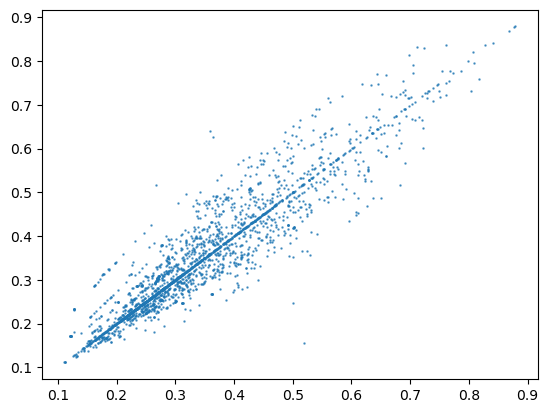

In [6]:
plt.scatter(score_pathology, score_facets, alpha = 0.7, s = 0.6)

In [7]:
called_ecDNA_in_both = 0
called_ecDNA_in_facets = 0
called_ecDNA_in_pathology = 0

for called in pathology_score_exists :
    if pathology.loc[pathology_score_exists[called], 'ecDNA_status'] == "ecDNA" :
        if called in facets_score_exists :
            if facets.loc[facets_score_exists[called], 'ecDNA_status'] == "ecDNA" :
                called_ecDNA_in_both += 1
            else :
                called_ecDNA_in_pathology += 1
        else :
            called_ecDNA_in_pathology += 1

for called in facets_score_exists :
    if facets.loc[facets_score_exists[called], 'ecDNA_status'] == "ecDNA" :
        if called in pathology_score_exists :
            if not facets.loc[facets_score_exists[called], 'ecDNA_status'] == "ecDNA" :
                called_ecDNA_in_facets += 1
        else :
            called_ecDNA_in_facets += 1

print(f"Both ecDNA: {called_ecDNA_in_both}")
print(f"Only ecDNA in FACETS purity: {called_ecDNA_in_facets}")
print(f"Only ecDNA in Pathology: {called_ecDNA_in_pathology}")

Both ecDNA: 245
Only ecDNA in FACETS purity: 10
Only ecDNA in Pathology: 71
